In [ ]:
!pip install -q tensorflow_similarity timeout_decorator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.4/230.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
from google.colab import drive
from datetime import datetime
import shutil
import matplotlib.pyplot as plt

# Specialized metric loss
from tensorflow_similarity.losses import MultiSimilarityLoss

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/AdrianHRedhe/ID2223_Project.git

Cloning into 'ID2223_Project'...
remote: Enumerating objects: 28738, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 28738 (delta 0), reused 8 (delta 0), pack-reused 28730
Receiving objects: 100% (28738/28738), 297.11 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (29792/29792), done.


# Put in ARGS

In [ ]:
gdrive_base_dir = '/content/drive/MyDrive/ID2223 - Project/'
git_base_dir = 'ID2223_Project/'

base_dir = gdrive_base_dir
metadata_df = pd.read_csv(f'{base_dir}current_images_metadata.csv')

model_version = 'V2'
min_photos_per_location = 4
batch_size = 32
layers_to_freeze = 40 #20 # 2
dataset_version = 'v1'
output_dim = 2048
n_epochs = 6

WITH_RESCALING = False
WITH_DENSE_LAYER = False
REMOVE_QUERY_IMG = True
READ_VIA_HOPSWORKS = False

# Use if you want to copy images from gdrive.
COPY_FILES_TO_COLAB = False


if READ_VIA_HOPSWORKS:
    import hopsworks
    project = hopsworks.login(api_key_value='3AUfzmkHodq2ve3J.kh15KYDb6Xckmn3QZnS5VN9JlX8BHYgAs8jO9xRXggnMEnW2Y9M2JQDZybAM8IX9')
    fs = project.get_feature_store()

    image_meta_data_fg = fs.get_feature_group('image_metadata_fg',version = 1)
    metadata_df = image_meta_data_fg.read(read_options={"use_hive": True})

if not dataset_version == None:
    metadata_df = metadata_df[metadata_df['dataset_version'] == dataset_version]

In [ ]:
if COPY_FILES_TO_COLAB:
    old_base_dir = base_dir
    base_dir = './'
    to_img_folder = 'Data/cropped_images'

    metadata_df.path_to_image = metadata_df.path_to_image.apply(lambda x: x.replace(old_base_dir + to_img_folder,base_dir + to_img_folder))

    shutil.copytree(old_base_dir + to_img_folder, base_dir + to_img_folder)

In [ ]:
if REMOVE_QUERY_IMG:
  metadata_df = metadata_df[metadata_df.is_query_image != True]

### Make the images accessible from dict

In [ ]:
# from timeout_decorator import timeout
# @timeout(0.3)
def from_path_to_image(path):
  bgr_image = cv2.imread(path)
  rgb_image = bgr_image[:, :, ::-1]
  return rgb_image

In [ ]:
path_to_img_dict = {}
paths = metadata_df.path_to_image.unique()

# 45 min when reading from gdrive vs 19 sec when copied info to colab

for i,path in enumerate(paths):
    path_to_img_dict[path] = np.array(from_path_to_image(path))

    if i % 2000 == 99:
        print(i, datetime.now())

99 2024-01-06 19:47:00.970220
2099 2024-01-06 19:47:04.493091
4099 2024-01-06 19:47:08.636707
6099 2024-01-06 19:47:12.944454
8099 2024-01-06 19:47:16.005155


### Create a Datagenerator class that can be used for different datasets / splits

In [ ]:
# HelperFunction for the data generator
def find_suitable_targets(metadata_df,no_id,ro_nr,number_of_tm_images=4):
    try:
        choices = metadata_df[(metadata_df.new_order_idx == no_id) & (metadata_df.rotation_nr == ro_nr)]
        indexes = np.random.choice(choices.index,number_of_tm_images,replace=False)
    except:
        count_images_per_rotation = metadata_df[(metadata_df.new_order_idx == 0)].groupby(['rotation_nr']).count().reset_index()
        new_rotation_nr = np.random.choice(count_images_per_rotation[count_images_per_rotation['picture_nr'] > 4].rotation_nr)

        choices = metadata_df[(metadata_df.new_order_idx == no_id) & (metadata_df.rotation_nr == new_rotation_nr)]
        indexes = np.random.choice(choices.index,number_of_tm_images,replace=False)

    paths = choices.loc[indexes].path_to_image.to_list()
    labels = choices.loc[indexes].google_location.to_list()
    uids = choices.loc[indexes].index

    return paths, labels, uids

In [ ]:
from keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, data, path_to_img_dict, batch_size, shuffle=True):
        self.all_data = data
        self.data = data
        self.path_to_img_dict = path_to_img_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))

        self.n_locations_per_batch = 8
        self.n_images_per_location = 4
        self.n_locations_in_dataset = len(self.data.new_order_idx.unique())

        if self.shuffle:
            np.random.shuffle(self.indexes)

        if self.batch_size == 16:
            self.n_locations_per_batch = 4

        if not self.batch_size in [16,32]:
            raise ValueError(f'Batch can only be 16 or 32 for now... was initialised as {batch_size}')

    def __len__(self):
        batches_in_dataset_per_rotation = np.floor(self.n_locations_in_dataset / self.n_locations_per_batch)
        return int(batches_in_dataset_per_rotation * 4)

    def __getitem__(self, index):


        new_order_indexes = np.random.choice(self.data.new_order_idx.to_list(), self.n_locations_per_batch, replace=False)
        rotation = np.random.choice(range(4),self.n_locations_per_batch)

        all_paths = []
        all_labels = []

        for no_id, ro_nr in zip(new_order_indexes, rotation):
            paths, labels, uids_to_remove = find_suitable_targets(metadata_df,no_id,ro_nr)
            all_paths += paths
            all_labels += labels

        batch_data = np.array([self.path_to_img_dict[path] for path in all_paths])
        batch_labels = np.array(all_labels)

        # Cleanup
        self._cleanup_used_data(uids_to_remove)

        return batch_data, batch_labels

    def _cleanup_used_data(self, uids_to_remove):
      all_uids = self.data.index
      uids_to_keep = [uid
                      for uid in all_uids
                      if not uid in uids_to_remove]

      self.data = self.data.loc[uids_to_keep]

    def on_epoch_end(self):
        self.data = self.all_data


## Define the architecture
ResNet Backbone
and then an aggregator   
on top of it. Inspiration has been taken from   
how this has been done so far in the field by   
researchers

### Backbone

In [ ]:
default_shape_resnet_50 = (224, 224, 3)
backbone = ResNet50(weights='imagenet', include_top=False, input_shape=default_shape_resnet_50)
backbone_output_shape = backbone.output.shape

# Freezing x bottom layers
if layers_to_freeze > 0:
    for layer in backbone.layers[:layers_to_freeze]:
        layer.trainable = False

### Aggregator

In [ ]:
# GeM layer as described here https://arxiv.org/abs/1711.02512 and
# implemented https://github.com/filipradenovic/cnnimageretrieval-pytorch
# on their github, but adapted for Tensorflow

# Original implementation, I have checked that both do give the same output.
# x = F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1./self.p)

def GeM(x):
  # Can make this hyper-param trainable but will not for now
  p = 3

  x = tf.math.maximum(x, 1e-6)
  x = tf.pow(x, p)
  x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)
  x = tf.pow(x, 1.0 / p)
  return x

In [ ]:
# As described in github.com / CosPlace implementation but adapted to TF instead of torch

aggregator_gem = models.Sequential()

# L2 Norm layer
aggregator_gem.add(layers.Lambda(lambda x: tf.nn.l2_normalize(x, 1), name='L2Norm_1'))

# GeM Layer
aggregator_gem.add(layers.Lambda(lambda x: GeM(x), name='GeM_Pooling_1'))

# Flatten layer
aggregator_gem.add(layers.Flatten())

# Linear layer as in CosPlace implementation
if WITH_DENSE_LAYER:
    aggregator_gem.add(layers.Dense(output_dim, activation=None))

# L2 Norm layer
aggregator_gem.add(layers.Lambda(lambda x: tf.nn.l2_normalize(x,1), name='L2Norm_2'))

aggregator_gem.build(input_shape=backbone_output_shape)

In [ ]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(224, 224, 3)))

if WITH_RESCALING:
    model.add(layers.Rescaling((.1/255)))

model.add(backbone)
model.add(aggregator_gem)

In [ ]:
model.summary()
model.compile('adam', loss=MultiSimilarityLoss())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential_2 (Sequential)   (None, 2048)              4196352   
                                                                 
Total params: 27784064 (105.99 MB)
Trainable params: 27471232 (104.79 MB)
Non-trainable params: 312832 (1.19 MB)
_________________________________________________________________


### Create the datagenerators

In [ ]:
training_metadata_df = metadata_df[metadata_df.dataset_type == 'Training']
training_data_generator = CustomDataGenerator(training_metadata_df, path_to_img_dict, batch_size=batch_size)

validation_metadata_df = metadata_df[metadata_df.dataset_type == 'Validation']
validation_data_generator = CustomDataGenerator(validation_metadata_df, path_to_img_dict, batch_size=batch_size)

#test_data_generator = CustomDataGenerator(metadata_df, path_to_img_dict, batch_size=batch_size)

### Define the callback_ I.e. how to save checkpoints.

In [ ]:
checkpoint__dirname = f'training/model_{model_version}_freeze{layers_to_freeze}_DenseLayer{WITH_DENSE_LAYER}_OutDim{output_dim}_rescaling{WITH_RESCALING}_batch{batch_size}_epochs{n_epochs}/'

checkpoint_path = gdrive_base_dir + checkpoint__dirname + 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

n_batches = len(training_data_generator)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=False,
    save_freq=3*n_batches # Every third batch
    )
#   monitor: str = 'val_loss', # save_best_only: bool = False,

#  If used the best_only option you can load it back using
#  model.load_weights(checkpoint_filepath)

model.save_weights(checkpoint_path.format(epoch=0))

### Train and save model

In [ ]:
# Train the model using the custom data generator
history = model.fit(training_data_generator,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    callbacks=[cp_callback],
                    use_multiprocessing=True,
                    validation_data = validation_data_generator,
                    workers=6
                    )

Epoch 1/6
92/92 [==============================] - 2305s 25s/step - loss: 0.9124 - val_loss: 0.9542
Epoch 2/6
92/92 [==============================] - 2230s 24s/step - loss: 0.9318 - val_loss: 0.9550
Epoch 3/6
91/92 [============================>.] - ETA: 20s - loss: 0.9564
Epoch 3: saving model to /content/drive/MyDrive/ID2223 - Project/training/model_V2_freeze40_WithDenseLayerInAGG_OutDim2048_noRescalingPreRes_batch32_epochs6/cp-0003.ckpt
92/92 [==============================] - 2270s 25s/step - loss: 0.9562 - val_loss: 0.9548
Epoch 4/6
92/92 [==============================] - 2196s 24s/step - loss: 0.9546 - val_loss: 0.9536
Epoch 5/6
92/92 [==============================] - 2187s 24s/step - loss: 0.9299 - val_loss: 0.9365
Epoch 6/6
91/92 [============================>.] - ETA: 20s - loss: 0.9378
Epoch 6: saving model to /content/drive/MyDrive/ID2223 - Project/training/model_V2_freeze40_WithDenseLayerInAGG_OutDim2048_noRescalingPreRes_batch32_epochs6/cp-0006.ckpt
92/92 [=============

In [ ]:
save_path_model = f'models/model_{model_version}_freeze{layers_to_freeze}_DenseLayer{WITH_DENSE_LAYER}_OutDim{output_dim}_rescaling{WITH_RESCALING}_batch{batch_size}_epochs{n_epochs}/'
model.save(gdrive_base_dir + save_path_model)

In [ ]:
history.history

{'loss': [0.9123573303222656,
  0.9317778944969177,
  0.956173300743103,
  0.9545928239822388,
  0.9299268126487732,
  0.9377075433731079],
 'val_loss': [0.9542291760444641,
  0.9549564123153687,
  0.9547751545906067,
  0.9535865783691406,
  0.9365490674972534,
  0.9479837417602539]}

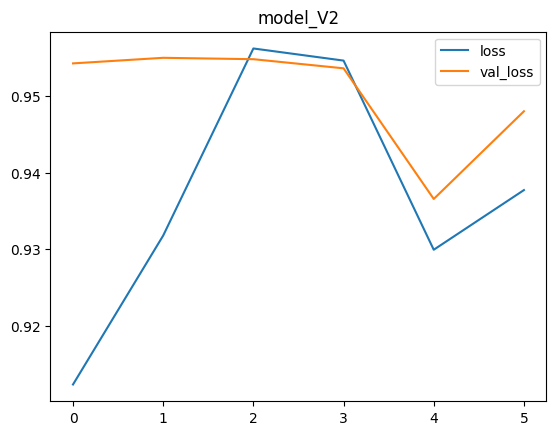

In [ ]:
# expect loss: 0.1853 / val_loss: 1.4360
plt.title(f'model_{model_version}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.savefig(f'{gdrive_base_dir}models/val_loss for model_{model_version}.png')
plt.show()

In [ ]:
reloaded_model = models.load_model('model_v1_save')

In [ ]:
x_batch,y_batch = validation_data_generator.__getitem__(32)

In [ ]:
y_hat = model.predict(x_batch)

1/1 [==============================] - 5s 5s/step


In [ ]:
y_hat.shape

(32, 2048)